In [2]:
import pandas as pd

In [6]:
df = pd.read_feather('../datasets/processed/creditcard_standardized.feather')

X = df.iloc[:, :-1]
print(f"full size = {X.shape[0]}")
X = X.to_numpy()

# X_sample = X.sample(n=int(X.shape[0] / 20), random_state=13, replace=False).to_numpy()
# print(f"x_sample size = {X_sample.shape[0]}")

full size = 284807


In [7]:
from bnp_gmm import BayesianNonparametricMixture

In [8]:

alpha_init = [2, 10]
truncated_k = 50
bnp = BayesianNonparametricMixture(alpha_init, truncated_k)

In [9]:
bnp.train(num_iterations=30, x_train=X)

weights = [3.05991606e-01 2.46096306e-01 4.09710675e-01 3.27054670e-03
 3.74636747e-03 2.72932359e-02 1.27516474e-04 3.46665393e-03
 2.52996050e-04 1.26317808e-05 3.09046910e-05 7.54651840e-08
 2.86154555e-08 3.77295513e-09 2.64249553e-08 1.06534962e-07
 1.68798775e-07 1.32339786e-07 1.22843406e-08 2.87470348e-09
 8.40029419e-10 3.31008143e-10 4.16577010e-10 4.08413137e-10
 1.00175278e-10 4.72961571e-10 1.69167733e-11 1.51225186e-11
 1.70512537e-13 4.22480999e-12 2.56038643e-13 2.31579937e-16
 1.67244810e-15 7.87541015e-16 1.61807797e-16 4.34379544e-17
 7.05511638e-17 1.25967683e-17 2.59257560e-17 6.86435333e-18
 2.27977688e-17 8.13613620e-18 4.02615022e-19 6.47123983e-19
 8.26262201e-19 1.34158345e-19 1.25906664e-20 9.15293583e-21
 3.42040232e-21 1.47556067e-21]
Now at iteration 0
expectations = [1.73807587e-01 1.43601166e-01 1.18644388e-01 9.80249060e-02
 8.09889315e-02 6.69136782e-02 5.52845957e-02 4.56765581e-02
 3.77383235e-02 3.11796930e-02 2.57609019e-02 2.12838549e-02
 1.758488

training with 50 truncated clusters for 30 iterations took ~26 hours

In [14]:
import pickle

with open('../models/posteriors.pkl', 'rb') as f:
    saved_posteriors = pickle.load(f)
    index = saved_posteriors['index']
    niw_posteriors = saved_posteriors['niw_posteriors']
    alpha_posteriors = saved_posteriors['alpha_posteriors'][index]
    sticks = saved_posteriors['sticks_list'][index]
    log_likelihoods = saved_posteriors['log_likelihoods']

In [48]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import numpy as np

plot the convergence of log_likelihood over the iterations

In [4]:
pio.renderers.default='notebook_connected'

In [15]:
iterations = np.arange(1, len(log_likelihoods) + 1)

df_convergence = pd.DataFrame({
    "Iteration" : iterations,
    "Log_likelihood" : log_likelihoods
})

fig = px.line(df_convergence, x="Iteration", y="Log_likelihood",
              markers=True, title="Log likelihoods over iterations")
fig.update_layout(template="plotly_white")
fig.show()

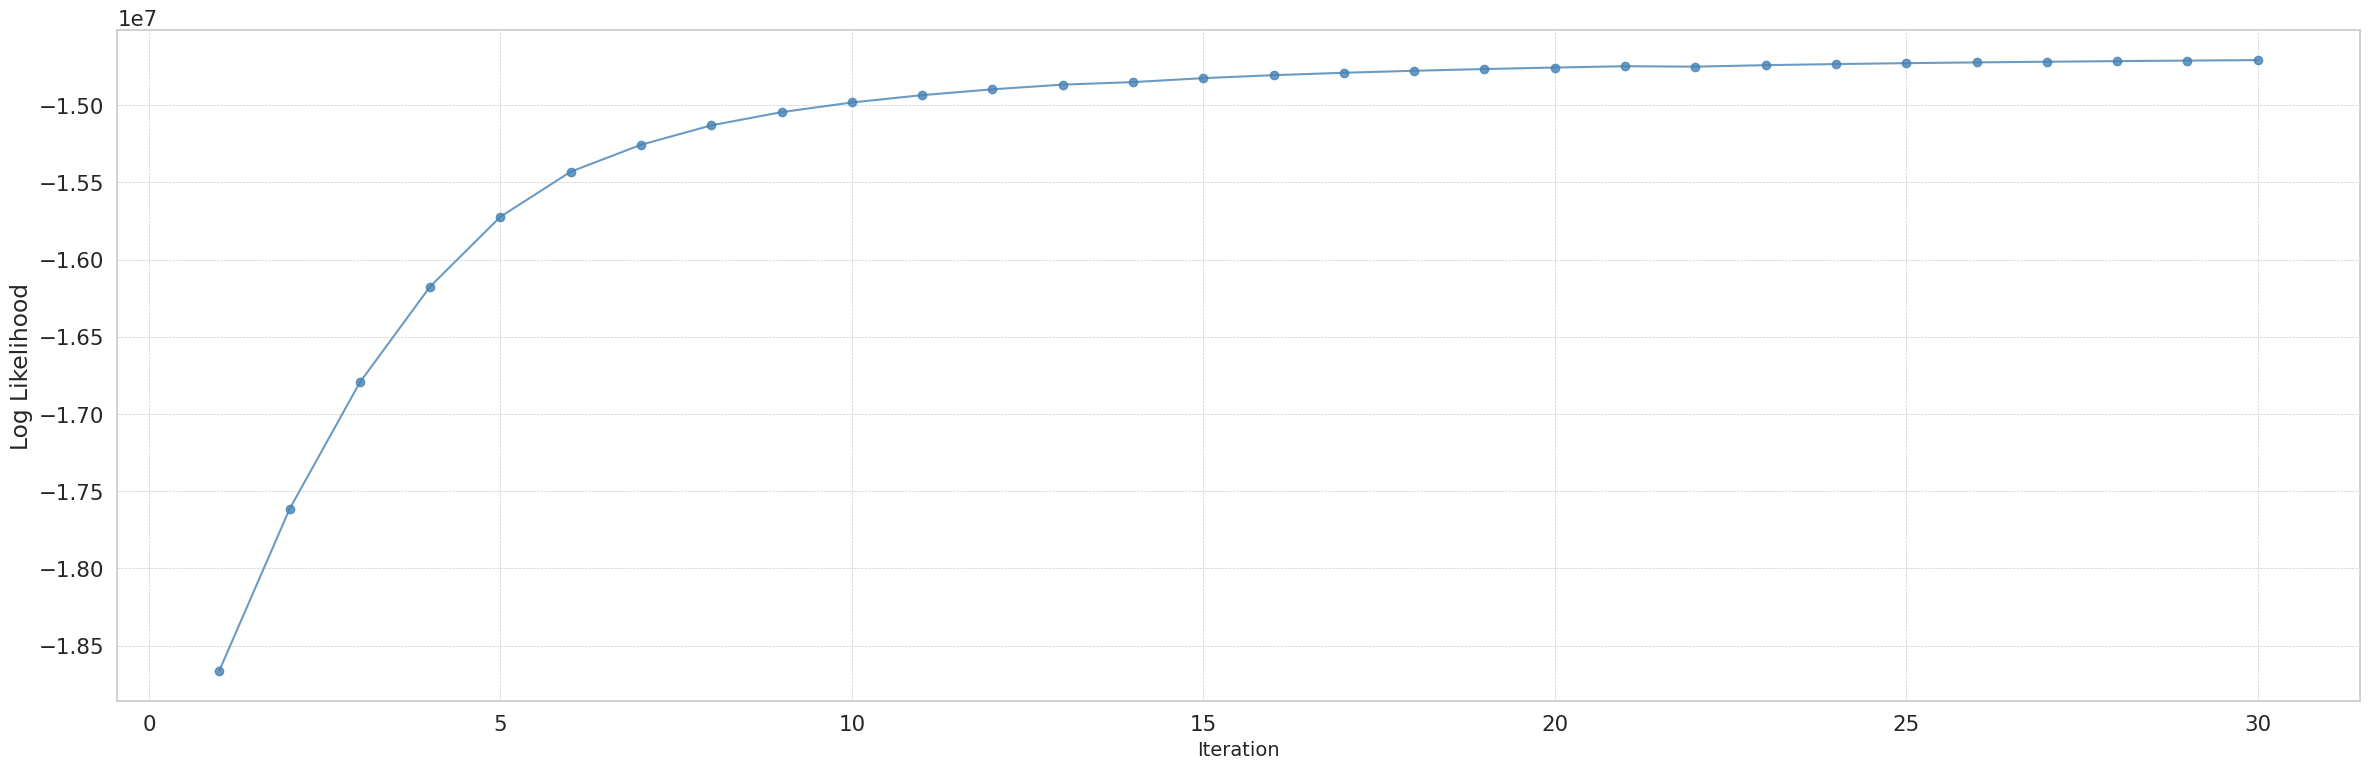

In [53]:
# plot and save fig with matplotlib
plt.figure(figsize=(24, 8))
sns.set_theme(style="whitegrid", font_scale=1.4)
plt.plot(iterations, log_likelihoods, marker='o', linestyle='-', color='steelblue', alpha=0.8)

plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Log Likelihood")

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.savefig("../assets/Log_likelihoods over iterations.png")


significant improvements in the first 10 iterations, afterwards the log likelihood plateaus; maybe stop training after 20, just to be safe

In [37]:
mixing_weights = [stick.weight for stick in sticks]
clusters = np.arange(1, len(mixing_weights) + 1)

df_weights = pd.DataFrame({
    "Cluster": clusters,
    "Weight": mixing_weights
})

fig = px.bar(df_weights, x="Cluster", y="Weight",
            title="Mixture weights per cluster",
            labels={"Cluster" : "Cluster index", "Weight" : "Mixture weight"})

fig.update_layout(template="plotly_white")
fig.add_hline(y=0.002, line_dash="dash", line_color="orange", 
              annotation_text="Active clusters threshold")  # 0.002 because of rounding errors
fig.show()

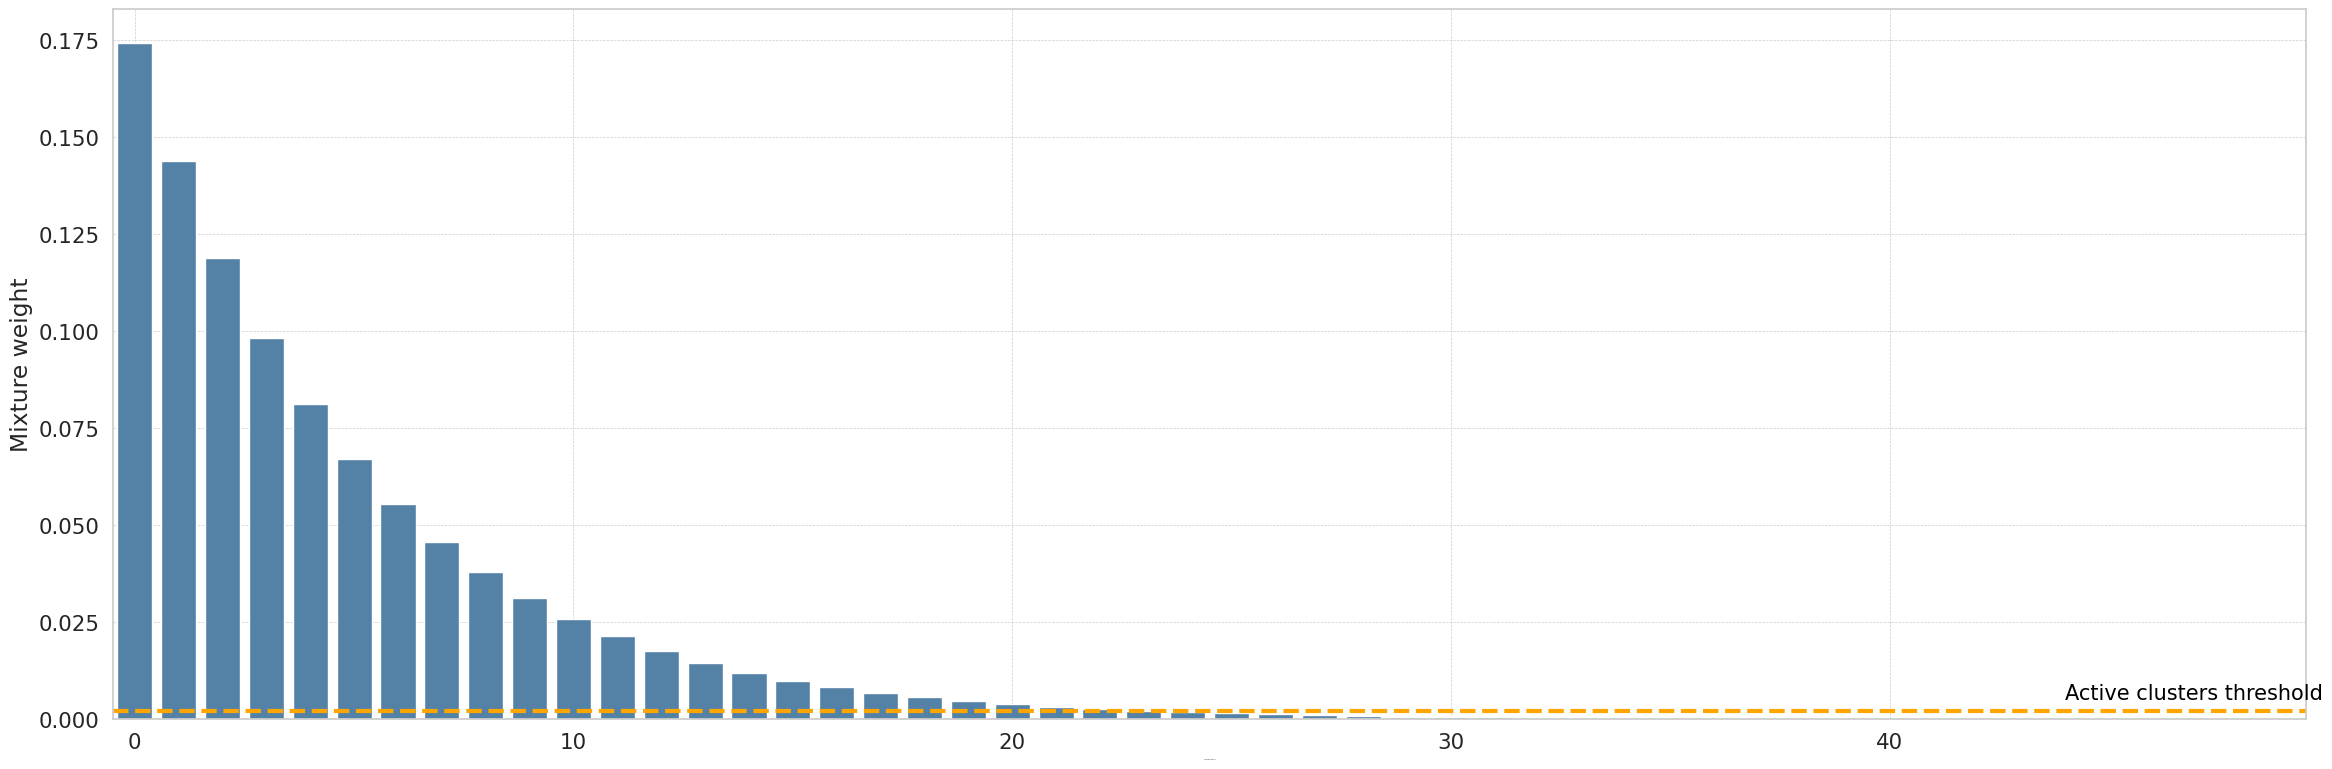

In [81]:
plt.figure(figsize=(24, 8))
sns.set_theme(style="whitegrid", font_scale=1.4)
sns.barplot(mixing_weights, color='steelblue')

plt.xlabel("Cluter index", fontsize=1.4)
plt.ylabel("Mixture weight")

plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.axhline(y=0.002, color='orange', linestyle='--', linewidth=3)
plt.text(x=len(mixing_weights) - 6, y=0.002 + 0.003, s='Active clusters threshold', color='black', fontsize=15)


plt.tight_layout()

plt.savefig("../assets/Clusters_weight.png")

K was truncated at 50, but the 'active' clusters (which had 99% of the total weight) were in fact only 24

In [28]:
print(f"Alpha_posteriors = {alpha_posteriors}")

Alpha_posteriors = [52 25]


alpha ~ Gamma(a, b), and E[alpha] = a/b <br> I conditioned it to be [2, 10] which encourages very few clusters to form (expected value = 2/10 ~ 0.2) <br> The aposteriori parameters, however, favour fragmented clusters [52, 25], with less density (expected value = 52/25 ~ 2), meaning that there are some regions in the data-space that are different than the others

In [ ]:
# compute the log likelihood of each instance, and flag as anomalous the top 1%